## This notebook walks through locally running mcad and ma bots using naive bot manager

In [11]:
# import necessary libaries 
%reload_ext autoreload
%autoreload 2
import os
os.chdir('..')

from scripts.apimanagers import APImanager
from scripts.assets import Account, Stock
from scripts.botmanagers import Stocks_manager_naive
from scripts.bots import Moving_average_bot, Macd_bot

import numpy as np
import pandas as pd
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import datetime
import time

### Initialization

In [12]:
# global variables
API_KEY = "PKI9JRCD2UOFVJTJEQ9Y"#<your API_KEY here>
SECRET_KEY = "JQAOBTno6yjE83Ks2tl8NpXnQEarMkMNrao1Hr0s"#<your SECRET_KEY here>
CUR_TIME_DELAYED = (datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(minutes=16))  # 16 minutes delay of current time for bars data
CUR_TIME = (datetime.datetime.now(datetime.timezone.utc))  # 15 minutes delay of current time for bars data
print(CUR_TIME_DELAYED)

2021-06-16 14:54:28.463380+00:00


In [13]:
# create API manager
API_manager = APImanager(API_KEY, SECRET_KEY)

In [14]:
# get some past data for initialization. Let's look at APPL and AMD for this demonstration
hour_bar_apple, hour_bar_apple_t = API_manager.get_bar("AAPL", TimeFrame.Hour, "2021-06-08", CUR_TIME_DELAYED.astimezone().isoformat())
hour_bar_amd, hour_bar_amd_t = API_manager.get_bar("AMD", TimeFrame.Hour, "2021-06-08", CUR_TIME_DELAYED.astimezone().isoformat())
minute_bar_bili, minute_bar_bili_t = API_manager.get_bar("BILI", TimeFrame.Minute, (CUR_TIME_DELAYED - datetime.timedelta(minutes=500)).astimezone().isoformat(), CUR_TIME_DELAYED.astimezone().isoformat())

#get current price of the stock for initialization.
cur_price_apple = API_manager.get_price("AAPL")
cur_price_amd = API_manager.get_price("AMD")
cur_price_bili = API_manager.get_price("BILI")

#print(minute_bar_bili, cur_price_bili, minute_bar_bili_t)

In [15]:
# create stock objects
APPL_hour = Stock("AAPL", cur_price_apple, CUR_TIME_DELAYED, hour_bar_apple, TimeFrame.Hour, hour_bar_apple_t[0])
AMD_hour = Stock("AMD", cur_price_amd, CUR_TIME_DELAYED, hour_bar_amd, TimeFrame.Hour, hour_bar_amd_t[0])
BILI_minute = Stock("BILI", cur_price_bili, CUR_TIME_DELAYED, minute_bar_bili, TimeFrame.Minute, minute_bar_bili_t[0])
STOCKS = [APPL_hour, AMD_hour, BILI_minute]

In [16]:
# create bot objects. Give each bot let's say $200,000 asset for trading
BOT_AAPL_ma_hour = Moving_average_bot(APPL_hour, 200000)
BOT_AMD_macd_hour = Macd_bot(AMD_hour, 200000)
BOT_BILI_macd_minute = Macd_bot(BILI_minute, 200000)
BOTS = [BOT_AAPL_ma_hour, BOT_AMD_macd_hour, BOT_BILI_macd_minute]

In [17]:
# create the bot manager
bot_manager = Stocks_manager_naive(BOTS, None)

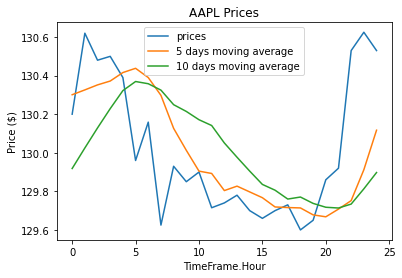

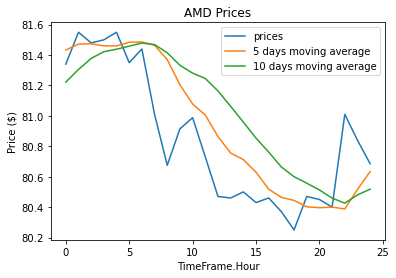

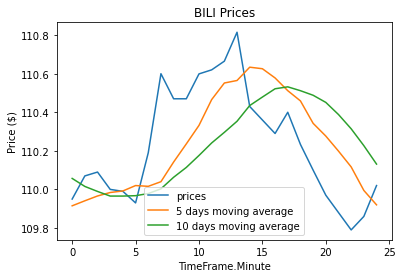

In [18]:
# print some prices for sanity check
APPL_hour.plot_price(25)
AMD_hour.plot_price(25)
BILI_minute.plot_price(25)

### The Main Loop

In [27]:
def update_utils():
    global CUR_TIME_DELAYED, CUR_TIME
    CUR_TIME_DELAYED = (datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(minutes=16))  # 16 minutes delay of current time for bars data
    CUR_TIME = (datetime.datetime.now(datetime.timezone.utc))  # 15 minutes delay of current time for bars data

def update_stocks(passed_minutes = 15): # assumes 15 minutes has passed since the last update
    for s in STOCKS:
        symbol = s.symbol
        timeframe = s.timeframe
        cur_price = API_manager.get_price(symbol)
        bar, bar_t = API_manager.get_bar(symbol, timeframe, (CUR_TIME_DELAYED - datetime.timedelta(minutes=passed_minutes)).astimezone().isoformat(), CUR_TIME_DELAYED.astimezone().isoformat())
        #print(bar, bar_t)
        s.update(cur_price, bar, bar_t, CUR_TIME_DELAYED)

def complete_actions(action_dict):
    for symbol in action_dict.keys():
        shares = action_dict[symbol]
        if shares < 0:
            #sell
            try:
                API_manager.sell_stocks(symbol, abs(shares))
                print("-> Successfully sold", abs(shares), "of", symbol,".")
            except:
                print("-> Selling", abs(shares), "of", symbol,"failed.")
        if shares > 0:
            #buy
            try:
                API_manager.buy_stocks(symbol, abs(shares))
                print("-> Successfully bought", abs(shares), "of", symbol,".")
            except:
                print("-> Buying", abs(shares), "of", symbol,"failed.")
        

In [ ]:
interation = 1
while True:    
    print("*** Iteration", interation)
    update_utils() # update the utility global variables such as CUR_TIME
    update_stocks() # update the stock objects
    print("Current time is", CUR_TIME, ". The delayed time is", CUR_TIME_DELAYED)
    action_dict = bot_manager.make_decision()
    complete_actions(action_dict)
    time.sleep(60) #make decision every 60 seconds
    print(" ")
    interation +=1
    

*** Iteration 1
[130.61] [datetime.datetime(2021, 6, 16, 15, 0, tzinfo=<UTC>)]
------
[130.61] [datetime.datetime(2021, 6, 16, 15, 0, tzinfo=<UTC>)]
------
[] []
[80.73] [datetime.datetime(2021, 6, 16, 15, 0, tzinfo=<UTC>)]
------
[80.73] [datetime.datetime(2021, 6, 16, 15, 0, tzinfo=<UTC>)]
------
[] []
[109.96, 109.7, 109.88, 109.9801, 109.79, 109.785, 109.94, 110.0, 110.05, 109.86, 109.79, 109.88, 109.97, 110.1, 110.2333] [datetime.datetime(2021, 6, 16, 15, 3, tzinfo=<UTC>), datetime.datetime(2021, 6, 16, 15, 2, tzinfo=<UTC>), datetime.datetime(2021, 6, 16, 15, 1, tzinfo=<UTC>), datetime.datetime(2021, 6, 16, 15, 0, tzinfo=<UTC>), datetime.datetime(2021, 6, 16, 14, 59, tzinfo=<UTC>), datetime.datetime(2021, 6, 16, 14, 58, tzinfo=<UTC>), datetime.datetime(2021, 6, 16, 14, 57, tzinfo=<UTC>), datetime.datetime(2021, 6, 16, 14, 56, tzinfo=<UTC>), datetime.datetime(2021, 6, 16, 14, 55, tzinfo=<UTC>), datetime.datetime(2021, 6, 16, 14, 54, tzinfo=<UTC>), datetime.datetime(2021, 6, 16, 14,

In [24]:
b = [2,1]
a = b[:-1]
print(a)

[2]
